# Loop model params :-)

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from numpy.random import seed # to set seed
from tensorflow.random import set_seed # to set seed
import pandas as pd

## Setting seed

In [2]:
# Apply seed
seed_value = 1338
set_seed(seed_value)
seed(seed_value)

## Image generator

Found 2076 images belonging to 2 classes.
Found 258 images belonging to 2 classes.
Found 262 images belonging to 2 classes.
Found 2076 images belonging to 2 classes.


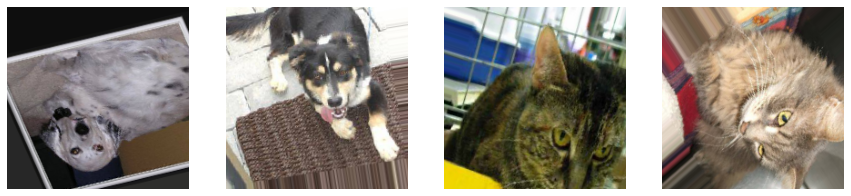

In [3]:
# Kopieret fra model_2.py 4/11 ~~11.30
#%% ImageDataGenerator

image_size = [200, 200]
batch = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip= True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_gen = train_datagen.flow_from_directory(
    'train',
    target_size=image_size,
    batch_size=batch,
    class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

val_gen = test_datagen.flow_from_directory(
        'val',
        target_size=image_size,
        batch_size=batch,
        class_mode='binary')

test_gen = test_datagen.flow_from_directory(
    'test',
    target_size=image_size,
    batch_size=batch,
    class_mode='binary')

#%% Visualizing ImageDataGenerator augmentation
train_datagen_viz = ImageDataGenerator(rotation_range=40,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip= True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_gen_viz = train_datagen_viz.flow_from_directory(
    'train',
    target_size=image_size,
    color_mode='rgb',
    batch_size=1,
    class_mode='binary',
    seed=1337)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
    image = next(train_gen_viz)[0].astype('uint8')
    
    image = np.squeeze(image)
    
    ax[i].imshow(image)
    ax[i].axis('off')

## Loop

In [92]:
# Units
con_layer_1 = [16, 32]
con_layer_2 = [32, 64]
con_layer_3 = [32, 64]
act_funcs = ['relu', 'selu', 'elu', 'tanh', 'sigmoid']
hidden_layer_1 = [256, 512]
dropout_sizes = [0.1, 0.2]
optimizers = ["adam", "sgd"]
epoch_n = 10

In [43]:
# Units for single test
con_layer_1 = [32]
con_layer_2 = [32]
con_layer_3 = [32]
act_funcs = ['relu']
hidden_layer_1 = [256]
dropout_sizes = [0.1]
optimizers = ["adam"]
epoch_n = 10

In [61]:
# Number of models to be created:
model_count = len(con_layer_1) * len(con_layer_2) * len(con_layer_3) * (len(act_funcs) * len(con_layer_1)) * (len(act_funcs) * len(con_layer_2)) * (len(act_funcs) * len(con_layer_3)) * len(dropout_sizes) * len(optimizers) * len(hidden_layer_1)

# Result array
results = pd.DataFrame(columns = ['loss',
                                  'val_loss',
                                  'accuracy',
                                  'val_accuracy',
                                  'con_layer_1',
                                  'con_layer_1_activation',
                                  'con_layer_2',
                                  'con_layer_2_activation',
                                  'con_layer_3',
                                  'con_layer_3_activation',
                                  'hidden_layer_1',
                                  'hidden_layer_1_activation',
                                  'dropout_sizes',
                                  'optimizers',
                                  'epoch',
                                  'epoch_n'])
print(f"There are {model_count} parameter combinations and {epoch_n} epochs")

There are 1 parameter combinations and 10 epochs


In [67]:
# Load results
results = pd.read_csv('loop_results.csv')
#results

,loss,val_loss,accuracy,val_accuracy,con_layer_1,con_layer_1_activation,con_layer_2,con_layer_2_activation,con_layer_3,con_layer_3_activation,hidden_layer_1,hidden_layer_1_activation,dropout_sizes,optimizers,epoch,epoch_n
0,0.724877,0.686644,0.511742,0.492188,32,relu,32,relu,32,relu,256,relu,0.1,adam,1,10
1,0.680808,0.643191,0.547945,0.613281,32,relu,32,relu,32,relu,256,relu,0.1,adam,2,10
2,0.663583,0.633924,0.601761,0.640625,32,relu,32,relu,32,relu,256,relu,0.1,adam,3,10
3,0.638368,0.631004,0.634540,0.632812,32,relu,32,relu,32,relu,256,relu,0.1,adam,4,10
4,0.642902,0.615302,0.625734,0.703125,32,relu,32,relu,32,relu,256,relu,0.1,adam,5,10
5,0.624896,0.633766,0.648239,0.652344,32,relu,32,relu,32,relu,256,relu,0.1,adam,6,10
6,0.622925,0.641407,0.654599,0.628906,32,relu,32,relu,32,relu,256,relu,0.1,adam,7,10
7,0.595109,0.621059,0.680528,0.625000,32,relu,32,relu,32,relu,256,relu,0.1,adam,8,10
8,0.597115,0.591301,0.692759,0.656250,32,relu,32,relu,32,relu,256,relu,0.1,adam,9,10
9,0.599171,0.602272,0.670254,0.644531,32,relu,32,relu,32,relu,256,relu,0.1,adam,10,10


In [93]:
# Loop tracking
count = 0 # To count loops
# Model loop
for con1 in con_layer_1:
    for con1_act in act_funcs:
        for con2 in con_layer_2:
            if(con1*3<con2):
                continue
            for con2_act in act_funcs:
                for con3 in con_layer_3:
                    if(con2*3<con3):
                        continue
                    for con3_act in act_funcs:
                        for hidden1 in hidden_layer_1:
                            for hidden1_act in act_funcs:
                                for dropout_size in dropout_sizes:
                                    for optimizer in optimizers:
                                        # Count and print progress
                                        count = count+1
                                        print(f'Training model {count} out of {model_count}')
                                        
                                        # Check if combination has been used
                                        if(len(results.loc[(results['con_layer_1'] == con1) &
                                                           (results['con_layer_1_activation'] <= con1_act) &
                                                           (results['con_layer_2'] == con2) &
                                                           (results['con_layer_2_activation'] == con2_act) &
                                                           (results['con_layer_3'] == con3) &
                                                           (results['con_layer_3_activation'] == con3_act) &
                                                           (results['hidden_layer_1'] == hidden1) &
                                                           (results['hidden_layer_1_activation'] == hidden1_act) &
                                                           (results['dropout_sizes'] == dropout_size) &
                                                           (results['optimizers'] == optimizer) &
                                                           (results['epoch_n'] <= epoch_n)])):
                                            print("Skipped redundant combination!")
                                        
                                        # Model baseret på model.py kopieret 04/11 ~11.30
                                        model = keras.Sequential([
                                            # First convolution
                                            layers.Conv2D(con1, (3,3), activation=con1_act, input_shape=(200, 200, 3)),
                                            layers.MaxPooling2D(2,2), # halving the image size 

                                            # Second convolution
                                            layers.Conv2D(con2, (3,3), activation=con2_act),
                                            layers.MaxPooling2D(2,2),

                                            # Third convolution
                                            layers.Conv2D(con3, (3,3), activation=con3_act),
                                            layers.MaxPooling2D(2,2),

                                            # Fourth convolution - hidden until after some finetuning
                                            #layers.Conv2D(64, (3,3), activation='relu'),
                                            #layers.MaxPooling2D(2,2),

                                            # Fifth convolution - hidden until after some finetuning
                                            #layers.Conv2D(64, (3,3), activation='relu'),
                                            #layers.MaxPooling2D(2,2),

                                            # Flatten results to feed into a Deep Nerual Net
                                            layers.Flatten(),

                                            # 512 neuron hidden layer
                                            layers.Dense(hidden1, activation=hidden1_act),
                                            
                                            # Dropout NEW!!!!!!
                                            layers.Dropout(dropout_size),

                                            # Binary output layer
                                            layers.Dense(1, activation='sigmoid')
                                            ])

                                        #model.summary() # model summary

                                        model.compile(
                                            loss='binary_crossentropy',
                                            optimizer=optimizer,
                                            metrics=['accuracy']) # compiling model
                                        
                                        # Model fitting fra model_2.py kopieret 4/11 ~11.30
                                        # Callbacks for tensorboard 
                                        tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs") # tensorboard --logdir ./logs

                                        # Step sizes for train, validation and testing
                                        STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
                                        STEP_SIZE_VAL=val_gen.n//val_gen.batch_size
                                        STEP_SIZE_TEST=test_gen.n//test_gen.batch_size

                                        # Fitting model
                                        history = model.fit(
                                            train_gen,
                                            steps_per_epoch=STEP_SIZE_TRAIN,
                                            epochs=epoch_n, # for at spare lidt tid
                                            validation_data=val_gen,
                                            validation_steps=STEP_SIZE_VAL,
                                            callbacks=[tensorboard_callback],
                                            verbose = False)
                                        
                                        # Get results (from history)
                                        history = history.history
                                        
                                        # Append each epoch
                                        for h in range(len(history['loss'])):
                                            row = {'loss':history['loss'][h],
                                                   'val_loss':history['val_loss'][h],
                                                   'accuracy':history['accuracy'][h],
                                                   'val_accuracy': history['val_accuracy'][h],
                                                   'con_layer_1': con1,
                                                   'con_layer_1_activation': con1_act,
                                                   'con_layer_2': con2,
                                                   'con_layer_2_activation': con2_act,
                                                   'con_layer_3': con3,
                                                   'con_layer_3_activation': con3_act,
                                                   'hidden_layer_1': hidden1,
                                                   'hidden_layer_1_activation': hidden1_act,
                                                   'dropout_sizes': dropout_size,
                                                   'optimizers': optimizer,
                                                   'epoch': (h+1),
                                                   'epoch_n': epoch_n}
                                            results = results.append(row, ignore_index=True)

print("All done")

Training model 1 out of 1


KeyboardInterrupt: 

In [78]:
results

,loss,val_loss,accuracy,val_accuracy,con_layer_1,con_layer_1_activation,con_layer_2,con_layer_2_activation,con_layer_3,con_layer_3_activation,hidden_layer_1,hidden_layer_1_activation,dropout_sizes,optimizers,epoch,epoch_n
0,0.724877,0.686644,0.511742,0.492188,32,relu,32,relu,32,relu,256,relu,0.1,adam,1,10
1,0.680808,0.643191,0.547945,0.613281,32,relu,32,relu,32,relu,256,relu,0.1,adam,2,10
2,0.663583,0.633924,0.601761,0.640625,32,relu,32,relu,32,relu,256,relu,0.1,adam,3,10
3,0.638368,0.631004,0.634540,0.632812,32,relu,32,relu,32,relu,256,relu,0.1,adam,4,10
4,0.642902,0.615302,0.625734,0.703125,32,relu,32,relu,32,relu,256,relu,0.1,adam,5,10
5,0.624896,0.633766,0.648239,0.652344,32,relu,32,relu,32,relu,256,relu,0.1,adam,6,10
6,0.622925,0.641407,0.654599,0.628906,32,relu,32,relu,32,relu,256,relu,0.1,adam,7,10
7,0.595109,0.621059,0.680528,0.625000,32,relu,32,relu,32,relu,256,relu,0.1,adam,8,10
8,0.597115,0.591301,0.692759,0.656250,32,relu,32,relu,32,relu,256,relu,0.1,adam,9,10
9,0.599171,0.602272,0.670254,0.644531,32,relu,32,relu,32,relu,256,relu,0.1,adam,10,10


In [84]:
con3

32

In [65]:
# Save model
results.to_csv('loop_results.csv',index=False)

## Bedste performende

In [23]:
#history

{'loss': [0.7373494505882263,
  0.6769900321960449,
  0.6789867281913757,
  0.6557652950286865,
  0.6421235203742981,
  0.6517491340637207,
  0.6261609792709351,
  0.6112854480743408,
  0.5904984474182129,
  0.5823456645011902],
 'accuracy': [0.5239726305007935,
  0.5601761341094971,
  0.5337573289871216,
  0.6071428656578064,
  0.626953125,
  0.5905088186264038,
  0.6477494835853577,
  0.662915825843811,
  0.6854207515716553,
  0.6888453960418701],
 'val_loss': [0.6904640793800354,
  0.7022988796234131,
  0.6891622543334961,
  0.6358612179756165,
  0.6774259209632874,
  0.621364414691925,
  0.5909384489059448,
  0.6060240864753723,
  0.5995606184005737,
  0.5941712856292725],
 'val_accuracy': [0.546875,
  0.5078125,
  0.5234375,
  0.63671875,
  0.578125,
  0.6328125,
  0.66796875,
  0.66796875,
  0.69140625,
  0.66015625]}

## Modeller der ikke har nået bedste performance:
